## Introducción al Análisis Exploratorio de Datos (EDA)

Antes de aplicar cualquier modelo, es fundamental comprender la naturaleza y distribución de nuestro dataset de flores:

- **Dimensiones y formato**  
  Revisar resoluciones, proporciones y tipo de archivo de cada imagen para detectar posibles inconsistencias.

- **Balance de clases**  
  Contar cuántas imágenes hay de “daisy” y “dandelion” en cada partición (`train`, `valid`, `test`) para garantizar un entrenamiento equitativo.

- **Distribución de color y píxeles**  
  Generar histogramas de los canales RGB y mapas de densidad de intensidad para identificar sesgos en iluminación o coloración.

- **Visualización de muestras**  
  Mostrar mosaicos de imágenes representativas para verificar variedad, calidad y posibles artefactos.

Este primer paso nos ayudará a seleccionar técnicas de preprocesado, decidir si es necesario balanceo o augmentación, y definir la arquitectura más adecuada para nuestros modelos.  


In [22]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# Paths to the dataset
DATA_DIR = 'data'
SPLITS = ['train', 'valid', 'test']
CLASSES = os.listdir(os.path.join(DATA_DIR, 'train'))  # e.g., ['daisy', 'dandelion']

In [24]:

def collect_image_metadata(data_dir):
    """
    Recorre las carpetas train, valid y test recogiendo:
    - Ruta de la imagen
    - Split (train/valid/test)
    - Clase (daisy/dandelion)
    - Formato (JPEG, PNG, etc.)
    - Tamaño (width, height)
    - Peso en bytes
    """
    records = []

    for split in SPLITS:
        for cls in CLASSES:
            folder = os.path.join(data_dir, split, cls)
            for fname in os.listdir(folder):
                path = os.path.join(folder, fname)
                try:
                    with Image.open(path) as img:
                        fmt = img.format
                        width, height = img.size
                    size_bytes = os.path.getsize(path)
                    records.append((path, split, cls, fmt, width, height, size_bytes))
                except Exception as e:
                    print(f"Error loading {path}: {e}")
    df = pd.DataFrame(records, columns=[
        'path', 'split', 'class', 'format', 'width', 'height', 'size_bytes'
    ])
    return df


In [25]:
def plot_class_balance(df):
    """
    Gráfico de barras de balance de clases por split
    """
    counts = df.groupby(['split', 'class']).size().unstack(fill_value=0)
    counts.plot(kind='bar', figsize=(8, 5))
    plt.title('Balance de clases por split')
    plt.xlabel('Split')
    plt.ylabel('Número de imágenes')
    plt.legend(title='Clase')
    plt.tight_layout()
    plt.show()

In [26]:
def plot_image_size_distribution(df):
    """
    Histograma de resoluciones (ancho y alto)
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].hist(df['width'], bins=30)
    axes[0].set_title('Distribución de anchos')
    axes[0].set_xlabel('Ancho (px)')
    axes[0].set_ylabel('Frecuencia')

    axes[1].hist(df['height'], bins=30)
    axes[1].set_title('Distribución de altos')
    axes[1].set_xlabel('Alto (px)')
    axes[1].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

In [27]:
def plot_color_histogram(image_path):
    """
    Histograma de color por canal (RGB) para una imagen dada
    """
    with Image.open(image_path) as img:
        arr = np.array(img)
    # Aplanar cada canal y trazar histograma
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(colors):
        channel = arr[:, :, i].flatten()
        plt.hist(channel, bins=256, alpha=0.5, label=col)
    plt.title(f'Histograma de color: {os.path.basename(image_path)}')
    plt.xlabel('Intensidad de píxel')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [28]:
def compute_pixel_statistics(df, sample_n=100):
    """
    Selecciona aleatoriamente imágenes de cada clase y split para analizar distribuciones de píxeles.
    """
    sample = df.groupby(['split', 'class']).sample(n=min(sample_n, len(df)), random_state=42)
    pixel_stats = []
    for idx, row in sample.iterrows():
        with Image.open(row['path']) as img:
            arr = np.array(img)
        pixel_stats.append({
            'split': row['split'],
            'class': row['class'],
            'mean': arr.mean(),
            'std': arr.std(),
            'min': arr.min(),
            'max': arr.max()
        })
    stats_df = pd.DataFrame(pixel_stats)
    return stats_df

In [30]:
df_meta = collect_image_metadata(DATA_DIR)
print(df_meta.head())

                                                path  split  class format  \
0  data\train\daisy\100080576_f52e8ee070_n_jpg.rf...  train  daisy   JPEG   
1  data\train\daisy\10172379554_b296050f82_n_jpg....  train  daisy   JPEG   
2  data\train\daisy\10172567486_2748826a8b_jpg.rf...  train  daisy   JPEG   
3  data\train\daisy\10172636503_21bededa75_n_jpg....  train  daisy   JPEG   
4  data\train\daisy\102841525_bd6628ae3c_jpg.rf.f...  train  daisy   JPEG   

   width  height  size_bytes  
0    512     512       27544  
1    512     512       44730  
2    512     512       36028  
3    512     512       28633  
4    512     512       46834  


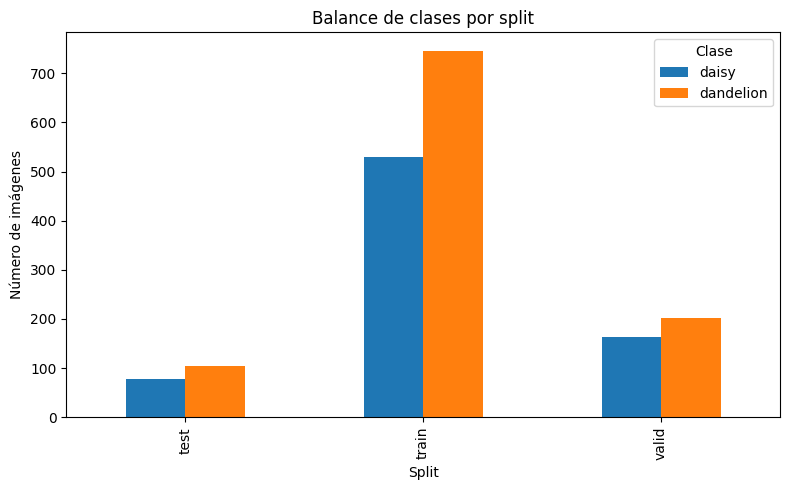

In [31]:
# Mostrar balance de clases
plot_class_balance(df_meta)

## Balance de Clases

Al analizar el número de imágenes por categoría, observamos que la clase **dandelion** tiene aproximadamente un 15 % más de muestras que la clase **daisy**. Esta ligera diferencia no compromete un entrenamiento equilibrado y puede considerarse aceptable para nuestros modelos.  


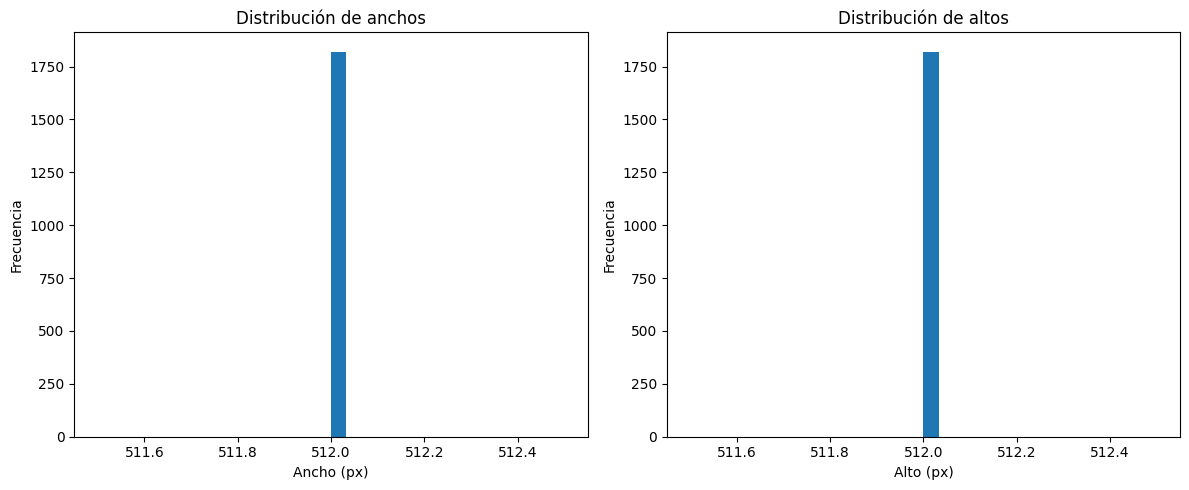

In [32]:
# Mostrar distribución de tamaños
plot_image_size_distribution(df_meta)

## Tamaño de las Imágenes

Todas las imágenes del dataset comparten la misma resolución, de modo que no es necesario realizar recortes o padding adicionales durante el preprocesado. Esto simplifica la construcción de los pipelines de entrada y garantiza uniformidad en las dimensiones de los tensores de entrada.  


In [33]:
# Estadísticas de píxeles
stats_df = compute_pixel_statistics(df_meta, sample_n=50)
print(stats_df.groupby(['split', 'class']).agg(['mean', 'std']))

                       mean                   std              min            \
                       mean        std       mean        std  mean       std   
split class                                                                    
test  daisy       95.066192  29.720138  66.165539  12.621804  0.00  0.000000   
      dandelion  102.935731  35.233614  62.125776  15.631470  0.76  3.473280   
train daisy      103.632873  40.316847  66.779861  13.405330  0.00  0.000000   
      dandelion   99.324376  36.846539  59.862694  14.803825  0.48  2.764498   
valid daisy       98.801301  41.269973  64.502457  16.434557  0.00  0.000000   
      dandelion  110.400333  30.041407  64.631123  14.604815  0.44  3.111270   

                    max            
                   mean       std  
split class                        
test  daisy      254.34  3.788328  
      dandelion  255.00  0.000000  
train daisy      254.00  4.598136  
      dandelion  252.48  7.691076  
valid daisy      252.84  7.

## Estadísticas de Intensidad de Pixel por Split y Clase

- **Canales R/G/B**: Las medias de los canales muestran que las imágenes de **dandelion** tienden a ser ligeramente más brillantes en rojo (110 vs 99–103) y presentan desviaciones similares en cada split.  
- **Mínimos**: Las margaritas (daisy) a menudo tienen píxeles completamente negros (0), mientras que los dientes de león (dandelion) raramente alcanzan 0, indicando un fondo ligeramente más iluminado.  
- **Máximos**: Ambos tipos alcanzan valores máximos muy cercanos a 255, con pequeñas variaciones en desviación estándar.  
- **Consistencia entre splits**: Los valores medios y sus desviaciones son homogéneos entre `train`, `valid` y `test`, lo que confirma que no hay sesgos de iluminación o contraste significativos en ninguna partición.  
